In [1]:
from pathlib import Path

import plotnine as pn
import scanpy as sc
import partipy as pt

import pandas as pd
import decoupler as dc


figure_dir = Path("figures") / "fibroblast_cross_condition"
figure_dir.mkdir(exist_ok=True, parents=True)
sc.settings.figdir = figure_dir

output_dir = Path("output") / "fibroblast_cross_condition"
output_dir.mkdir(exist_ok=True, parents=True)

n_archetypes = 3
obsm_key = "X_pca_harmony"
obsm_dim = 16

color_dict = {
    "NF": "#01665E",  # teal (blue-green)
    "CM": "#8C510A",  # brown
}

adata = pt.read_h5ad("/home/pschaefer/fibroblast_cross_condition_partipy.h5ad")

msigdb_cache_path = output_dir / "msigdb_raw.pkl"
needs_cache_write = False
if msigdb_cache_path.exists():
    msigdb_raw = pd.read_pickle(msigdb_cache_path)
else:
    msigdb_raw = dc.op.resource("MSigDB")
    needs_cache_write = True

if msigdb_raw.duplicated(["geneset", "genesymbol"]).any():
    msigdb_raw = msigdb_raw[~msigdb_raw.duplicated(["geneset", "genesymbol"])].copy()
    needs_cache_write = True

if needs_cache_write:
    msigdb_raw.to_pickle(msigdb_cache_path)

aa_out = pt.get_aa_result(adata, n_archetypes=3)
adata.obs["archetype_max_weight"] = aa_out["A"].argmax(axis=1)

/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.


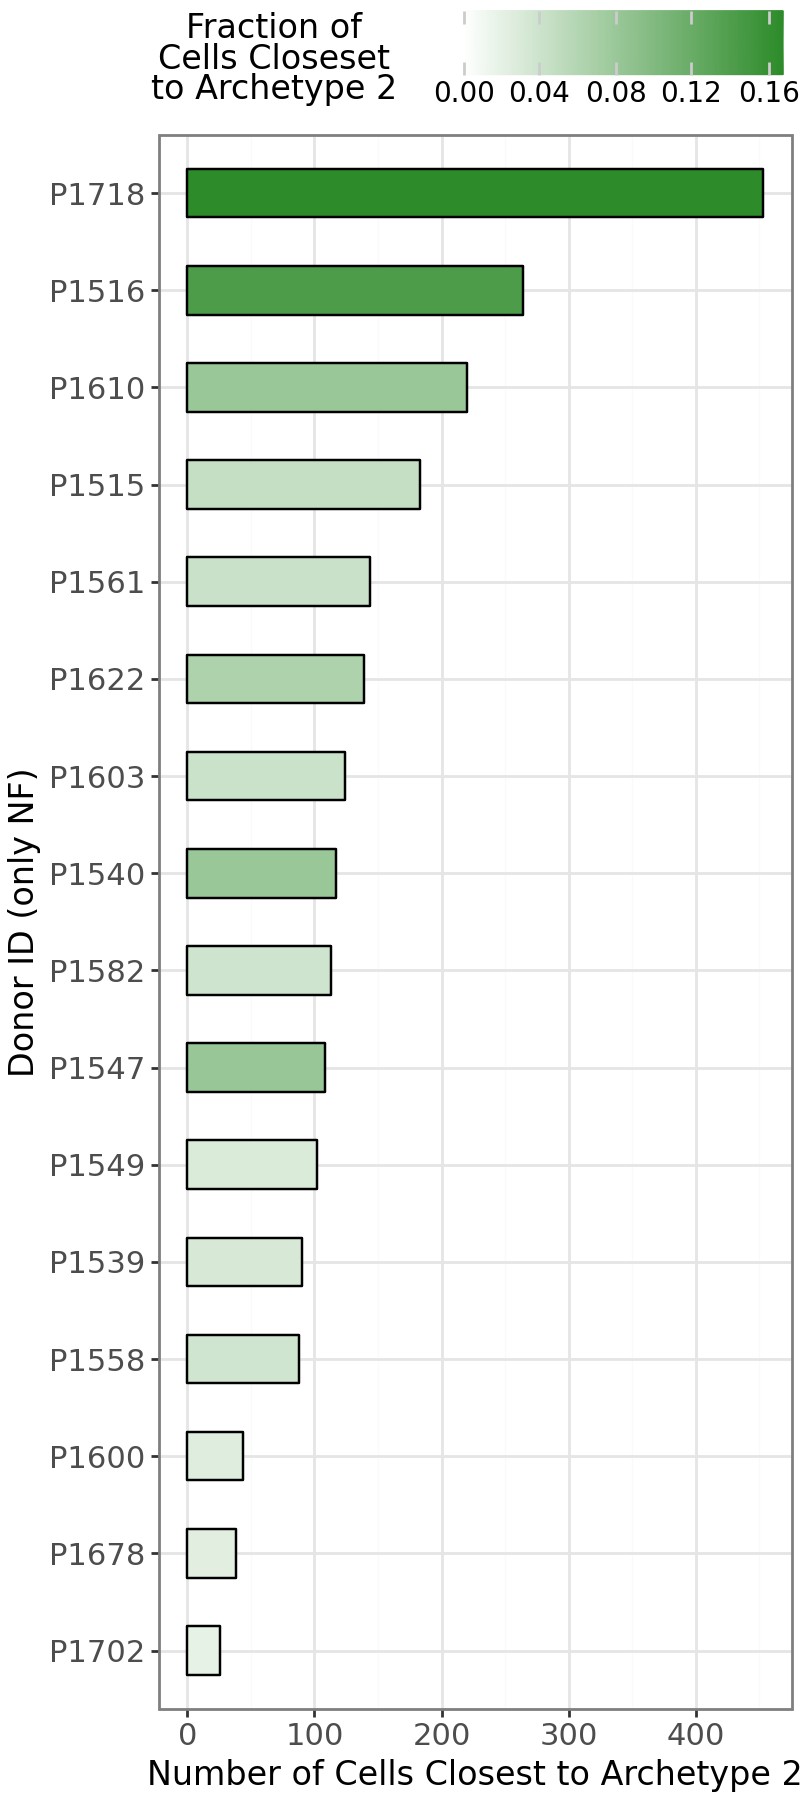

In [2]:
from mizani.bounds import squish

df = (
    adata.obs.value_counts(["disease", "donor_id", "archetype_max_weight"])
    .reset_index()
    .query("archetype_max_weight==2")
    .join(
        adata.obs.value_counts("donor_id")
        .reset_index()
        .rename(columns={"count": "total_cells"})
        .set_index("donor_id"),
        on="donor_id",
    )
)
df["fraction"] = df["count"] / df["total_cells"]

df_nf = df.query("disease=='NF'").copy()
df_nf = df_nf.sort_values("count", ascending=False)
df_nf["donor_id"] = pd.Categorical(
    df_nf["donor_id"],
    categories=df_nf["donor_id"],
    ordered=True,
)

order = df_nf.sort_values("count", ascending=False)["donor_id"].tolist()

p = (
    pn.ggplot(df_nf)
    + pn.geom_col(pn.aes(x="donor_id", y="count", fill="fraction"), width=0.50, color="black")
    + pn.scale_x_discrete(limits=order[::-1])  # reverse so largest ends up on top after coord_flip
    + pn.coord_flip()
    + pn.theme_bw()
    + pn.labs(
        x="Donor ID (only NF)",
        y="Number of Cells Closest to Archetype 2",
        fill="Fraction of\nCells Closeset\nto Archetype 2",
    )
    + pn.scale_fill_gradient2(
        low="#f7fbff",  # very light
        high="#2d8b2a",  # dark
        limits=(0, df_nf["fraction"].max()),
        oob=squish,
    )
    + pn.theme(
        figure_size=(4, 9),

        legend_position="top",
        legend_direction="horizontal",

        axis_title_x=pn.element_text(size=12),
        axis_title_y=pn.element_text(size=12),

        axis_text_x=pn.element_text(size=11),
        axis_text_y=pn.element_text(size=11),

        legend_title=pn.element_text(size=12),
        legend_text=pn.element_text(size=10),
    )
)
p.show()

In [8]:
import numpy as np

np.median(df_nf["count"])

np.float64(115.0)

In [9]:
np.median(df_nf["fraction"])

np.float64(0.04251313828535572)

In [3]:
p.save(figure_dir / "nf_cells_close_to_archetype_2.pdf", verbose=False)

In [ ]:
(
    pn.ggplot(df.query("disease=='NF'"))
    + pn.geom_col(pn.aes(x="donor_id", y="count", fill="fraction"))
    + pn.coord_flip()
    + pn.theme_bw()
    + pn.labs(
        x="Donor ID",
        y="Number of Cells Closest to Archetype 2",
        fill="Fraction of Cells\nCloseset to Archetype 2",
    )
    + pn.theme(
        figure_size=(5, 6),
        legend_position="top",
        legend_direction="horizontal",
    )
)

In [ ]:
p = (
    pt.plot_archetypes_2D(
        adata=adata,
        dimensions=[0, 1],
        show_contours=True,
        color="disease",
        alpha=0.0,
        size=0.5,
        result_filters={"n_archetypes": n_archetypes},
    )
    # draw points again with alpha mapped by disease
    + pn.geom_point(
        data=plot_df,
        mapping=pn.aes(x="pc_0", y="pc_1", alpha="disease", color="disease"),
        size=0.5,
    )
    + pn.scale_color_manual(values=color_dict)
    + pn.scale_alpha_manual(values={"NF": 0.0, "CM": 0.05}, breaks=[])
    + pn.guides(color=pn.guide_legend(override_aes={"alpha": 1.0, "size": 5}))
    + pn.theme_bw()
    + pn.labs(x="PC 0", y="PC 1", color="Disease\nStatus")
    + pn.coord_equal()
    + pn.theme(
        legend_key=pn.element_rect(fill="white", color="white"),
        legend_background=pn.element_rect(fill="white", color="black"),
        axis_title_x=pn.element_text(size=16),
        axis_title_y=pn.element_text(size=16),
        axis_text=pn.element_text(size=13),
    )
)
p.save(
    figure_dir / "plot_archetypes_2D_disease_pc1_pc_2_only_CM.png",
    verbose=False,
    dpi=300,
)

p = (
    pt.plot_archetypes_2D(
        adata=adata,
        dimensions=[0, 1],
        show_contours=True,
        color="disease",
        alpha=0.0,
        size=0.5,
        result_filters={"n_archetypes": n_archetypes},
    )
    # draw points again with alpha mapped by disease
    + pn.geom_point(
        data=plot_df,
        mapping=pn.aes(x="pc_0", y="pc_1", alpha="disease", color="disease"),
        size=0.5,
    )
    + pn.scale_color_manual(values=color_dict)
    + pn.scale_alpha_manual(values={"NF": 0.05, "CM": 0.0}, breaks=[])
    + pn.guides(color=pn.guide_legend(override_aes={"alpha": 1.0, "size": 5}))
    + pn.theme_bw()
    + pn.labs(x="PC 0", y="PC 1", color="Disease\nStatus")
    + pn.coord_equal()
    + pn.theme(
        legend_key=pn.element_rect(fill="white", color="white"),
        legend_background=pn.element_rect(fill="white", color="black"),
        axis_title_x=pn.element_text(size=16),
        axis_title_y=pn.element_text(size=16),
        axis_text=pn.element_text(size=13),
    )
)
p.save(
    figure_dir / "plot_archetypes_2D_disease_pc1_pc_2_only_HF.png",
    verbose=False,
    dpi=300,
)

In [ ]:
import plotnine as pn

# Make a plotting data frame with the coordinates used for plotting
# (adjust if your pt.plot_archetypes_2D uses different columns)
plot_df = adata.obs.copy()
plot_df["pc_0"] = adata.obsm["X_pca_harmony"][:, 0]
plot_df["pc_1"] = adata.obsm["X_pca_harmony"][:, 1]

color_dict = {"NF": "#01665E", "CM": "#8C510A"}
alpha_dict = {"NF": 0.05, "CM": 0.0}

p = (
    pt.plot_archetypes_2D(
        adata=adata,
        dimensions=[0, 1],
        show_contours=True,
        color="disease",
        # IMPORTANT: don't fix alpha here if you want per-condition alpha
        alpha=0.0,
        size=0.5,
        result_filters={"n_archetypes": n_archetypes},
    )
    # draw points again with alpha mapped by disease
    + pn.geom_point(
        data=plot_df,
        mapping=pn.aes(x="pc_0", y="pc_1", alpha="disease", color="disease"),
        size=0.5,
    )
    + pn.scale_color_manual(values=color_dict)
    + pn.scale_alpha_manual(values=alpha_dict, breaks=[])
    + pn.guides(color=pn.guide_legend(override_aes={"alpha": 1.0, "size": 5}))
    + pn.theme_bw()
    + pn.labs(x="PC 0", y="PC 1", color="Disease\nStatus")
    + pn.coord_equal()
    + pn.theme(
        legend_key=pn.element_rect(fill="white", color="white"),
        legend_background=pn.element_rect(fill="white", color="black"),
        axis_title_x=pn.element_text(size=16),
        axis_title_y=pn.element_text(size=16),
        axis_text=pn.element_text(size=13),
    )
)
p.show()

In [ ]:
import numpy as np

pt.compute_archetype_weights(
    adata=adata, mode="automatic", result_filters={"n_archetypes": n_archetypes}
)
# NOTE: here we make sure that the weights per archetype sums to one
weights = pt.get_aa_cell_weights(adata, n_archetypes=n_archetypes)
weights /= weights.sum(axis=0, keepdims=True)
assert np.allclose(weights.sum(axis=0), 1, rtol=1e-3)

In [ ]:
# add weigths to adata.obs for plotting
for arch_idx in range(n_archetypes):
    adata.obs[f"weigths_for_arch_{arch_idx}"] = weights[:, arch_idx].copy()

In [ ]:
for arch_idx in range(n_archetypes):
    p = (
        pt.plot_archetypes_2D(
            adata=adata,
            dimensions=[0, 1],
            show_contours=True,
            color=f"weigths_for_arch_{arch_idx}",
            alpha=0.05,
            size=0.5,
            result_filters={"n_archetypes": n_archetypes},
        )
        + pn.theme_bw()
        + pn.guides(color=pn.guide_legend(override_aes={"alpha": 1.0, "size": 5}))
        + pn.labs(x="PC 0", y="PC 1")
        + pn.coord_equal()
        + pn.theme(
            legend_key=pn.element_rect(fill="white", color="white"),
            legend_background=pn.element_rect(fill="white", color="black"),
            axis_title_x=pn.element_text(size=16),
            axis_title_y=pn.element_text(size=16),
            axis_text=pn.element_text(size=13),
        )
    )
    p.save(
        figure_dir / f"plot_archetypes_2D_weigths_{arch_idx}_pc0_pc_1.png",
        verbose=False,
    )

In [ ]:
adata.obs.value_counts("disease").reset_index().rename(
    columns={"count": "total_disease_count"}
).set_index("disease")

In [ ]:
n_closest_cells = len(adata.obs) // 10
print(n_closest_cells)

df = (
    adata.obs.sort_values("weigths_for_arch_2", ascending=False)
    .head(n_closest_cells)
    .value_counts(["disease", "donor_id"])
    .reset_index()
    .join(
        adata.obs.value_counts("disease")
        .reset_index()
        .rename(columns={"count": "total_disease_count"})
        .set_index("disease"),
        on="disease",
    )
)
df["count_normalized"] = df["count"] / df["total_disease_count"]  # * n_closest_cells
df = df.sort_values("count_normalized", ascending=False)
df["log10_count"] = np.log10(df["count"])
df["rank"] = 1 + (-1 * df["count_normalized"].to_numpy()).argsort().argsort()
df

In [ ]:
p = (
    pn.ggplot(df)
    + pn.geom_point(pn.aes(x="rank", y="count_normalized", color="disease"), size=3)
    + pn.scale_color_manual(values=color_dict)
    + pn.theme_bw()
)
p.show()

In [ ]:
p = (
    pn.ggplot(df)
    + pn.geom_point(
        pn.aes(x="rank", y="count_normalized", color="log10_count", shape="disease"),
        size=3,
    )
    + pn.theme_bw()
    + pn.labs(
        x="Donor Rank",
        y="Normalized Count",
        shape="Disease\nStatus",
        color="Log10 Cell Count",
    )
)
p.show()

In [ ]:
p = (
    pn.ggplot(df)
    + pn.geom_point(
        pn.aes(x="rank", y="count_normalized", color="log10_count", shape="disease"),
        size=3,
    )
    + pn.theme_bw()
    + pn.labs(
        x="Donor Rank",
        y="Normalized Count",
        shape="Disease\nStatus",
        color="Log10 Cell Count",
    )
    + pn.scale_y_log10()
)
p.show()

In [ ]:
adata.obs.sort_values("weigths_for_arch_2", ascending=False).head(10_000).value_counts(
    "donor_id"
)